color_evol
----------

This notebook produces figure 3 of the review by Krumholz, McKee, & Bland-Hawthorn (2019, ARA&A, submitted). It operates on the outputs of a SLUG simulation ([da Silva, Fumagalli, & Krumholz, 2012, ApJ, 75, 145](http://adsabs.harvard.edu/abs/2012ApJ...745..145D), [Krumholz et al., 2015, MNRAS, 452, 1447](http://adsabs.harvard.edu/abs/2015MNRAS.452.1447K)), which is included in the repository.

In addition to the standard dependencies of all notebooks in this repository, this notebook requires [Stochastically Lighting Up Galaxies (SLUG)](https://bitbucket.org/krumholz/slug2). The SLUG parameter file that generated the tracks is included in the `data` subdirectory of the repository as `clusters_araa.param`, but the tracks are also included, so they do not need to be regenerated. However, the slugpy python library portion of the SLUG package is still required to read the tracks.

In [1]:
%matplotlib inline

In [2]:
from slugpy import read_cluster
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path as osp

In [3]:
# Read the SLUG run; make shortcut to various outputs
data = read_cluster(osp.join('data', 'cluster_tracks'))
logt = np.log10(data.time)

In [4]:
# Make a funky color map by combining three others
c1 = plt.cm.Greens(np.linspace(0,1,256//3))
c2 = plt.cm.Blues(np.linspace(0,1,256//3))
c3 = plt.cm.Reds(np.linspace(0,1,256//3))
clr = np.vstack((c1, c2, c3))
cmap = mpl.colors.LinearSegmentedColormap.from_list('split_map', clr)
norm  = mpl.colors.Normalize(vmin=6, vmax=9)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

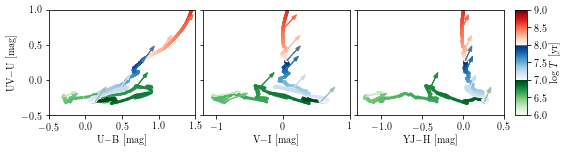

In [5]:
# Make color-color plots
fig=plt.figure(1, figsize=(8,2))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.clf()

# Control parameters
skip=5
arrow_times = [6.25, 6.5, 6.75, 7.0, 7.25, 7.25, 7.75, 8.0, 8.25, 8.5, 8.75]
head_width=0.05

# Make a dummy plot to have a mappable we can use to make a colorbar
dummy_z = [[0,0],[0,0]]
dummy_mappable = plt.imshow(dummy_z, cmap=cmap, vmin=6, vmax=9)
plt.clf()

# Filter combinations on x and y axes
x_colors = [['WFC3_UVIS_F336W', 'WFC3_UVIS_F438W'],
            ['WFC3_UVIS_F555W', 'WFC3_UVIS_F814W'],
            ['WFC3_IR_F110W', 'WFC3_IR_F160W']
           ]
x_labels = [['U', 'B'],
            ['V', 'I'], 
            ['YJ', 'H']]
x_lim = [[-0.5, 1.5], 
         [-1.2, 1], 
         [-1.3, 0.5]]
y_colors = ['WFC3_UVIS_F225W', 'WFC3_UVIS_F336W']
y_labels = ['UV', 'U']
y_lim = [-0.5,1]

# Get color on y axis
cy = data.phot_neb[:,data.filter_names.index(y_colors[0])] - \
     data.phot_neb[:,data.filter_names.index(y_colors[1])]
cy_ex = data.phot_neb_ex[:,data.filter_names.index(y_colors[0])] - \
        data.phot_neb_ex[:,data.filter_names.index(y_colors[1])]

# Make panels
for n in range(len(x_colors)):
    
    # Make panel
    #plt.subplot(2,(len(x_colors)+1)//2,n+1)
    plt.subplot(1,len(x_colors),n+1)
    
    # Get color on x axis
    cx = data.phot_neb[:,data.filter_names.index(x_colors[n][0])] - \
         data.phot_neb[:,data.filter_names.index(x_colors[n][1])]
    cx_ex = data.phot_neb_ex[:,data.filter_names.index(x_colors[n][0])] - \
            data.phot_neb_ex[:,data.filter_names.index(x_colors[n][1])]

    # Plot track
    for i in range(len(cx)//skip-1):

        # Unextincted track
        j = i*skip
        plt.plot(cx[j:j+skip], cy[j:j+skip], lw=3, color=mapper.to_rgba(logt[j]))
    
        # Add A_V = 1 arrows
        if np.sum([np.isclose(logt[j], t) for t in arrow_times]):
            plt.arrow(cx[j], cy[j], cx_ex[j]-cx[j], cy_ex[j]-cy[j],
                  color=mapper.to_rgba(logt[j]),
                  length_includes_head=True,
                  head_width=head_width,
                  zorder=10)

    # Adjust limits and labels
    plt.xlim(x_lim[n])
    plt.ylim(y_lim)
    plt.xlabel(r'{:s}$-${:s} [mag]'.format(x_labels[n][0], x_labels[n][1]))
    #if n % ((len(x_colors)+1)//2) == 0:
    if n == 0:
        plt.ylabel(r'{:s}$-${:s} [mag]'.format(y_labels[0], y_labels[1]))
    else:
        plt.gca().set_yticklabels([])

# Adjust spacing
plt.subplots_adjust(wspace=0.05, left=0.1, bottom=0.22, top=0.95, right=0.89, hspace=0.3)

# Add colorbar
cax = fig.add_axes([0.91, 0.22, 0.02, 0.95-0.22])
fig.colorbar(dummy_mappable, cax=cax, label=r'$\log\,T$ [yr]')

# Save
plt.savefig(osp.join('figures', 'color_evol.pdf'))